# Content and Objective

+ Show estimation of psd w. Yule-Walker
+ Method: Get noise, filtered noise and sinusoid, and perform psd estimation

In [1]:
# importing
import numpy as np
from scipy import signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 36}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 8) )

# Helper Functions

### Functions for estimating spectra 

In [3]:
########################
# periodogram estimator
########################
def find_periodogram(y, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    
    IN: observation y, frequencies
    OUT: psd estimator
    """
    N = len(y)
    per = np.zeros(len(omega), dtype=complex) 
        
    for p in np.arange(0, N):
        per += y[p] * np.exp( -1j * omega * (p+1) )
        
    per = ( abs(per)**2 )/ N
        
    return per  



########################
# acf estimator
########################
def est_acf(y, est_type):
    """
    estimates acf given a number of observation
    
    Remark: signal is assumed to be starting from 0 to length(y)-1
    
    IN: observations y, est_type (biased / unbiased)
    OUT: estimated acf, centered around 0
    """
    
    N = np.size( y )
    r = np.zeros_like( y )
    
    # loop lags of acf
    for k in np.arange(0, N):
        
        temp = np.sum( y[k:N] * np.conjugate(y[0:(N-k)]) )

        # type of estimator
        if est_type == 'biased':
            r[k] = temp/N
        elif est_type == 'unbiased':
            r[k] = temp/(N-k)
        
    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])     
   
    return  np.append(r_reverse[0:len(r)-1], r) 



########################
# Yule Walker periodogram estimator
########################
def find_yulewalker(y, order, s2, omega):
    """
    estimates periodogram using the Yule-Walker method
    
    IN: acf r, YW oder q, noise variance, frequencies
    OUT: psd estimator
    """

    per = np.zeros(len(omega), dtype=complex)

    r = est_acf(y, 'biased') 
    #r = r/np.max(acf)
    N = int( (len(r)+1)/2 )

    # get matrix R for Yule-Walker     
    # note that R is not the autocorrelation matrix, but R = (ACF matrix)^*
    R = np.zeros([order+1, order+1], dtype=complex)        
    for p in range(0, order+1):
        R[:,p] = r[N-1-p : N-1-p+order+1 ]


    # find and solve linear equation system for the coefficients
    b = np.matrix(np.append(s2, np.zeros(order))).T
    theta = np.linalg.solve(R, b)
    theta = np.array(theta / theta[0])

    # get frequency response    
    for p in np.arange(0, order+1):
        per += theta[p]*np.exp(-1j*omega*p)
        
    return s2 / abs(per)**2

# Parameters

In [4]:
# number of samples and according time vector
N = int( 1e3 )
N_vec = np.arange(0, N)

# order of Yule-Walker approach; q<N required
q = 3
q_2 = 170

# variance of noise used in the illustration
sigma2 = 2

# frequencies of two sinusoids
Omega_0 = 1.0
Omega_1 = 1.2
    
    
# number of realizations for averaging    
N_real = int( 1e2 )

# number of freq. points and freq. range
N_freq = 512            
Ome = np.linspace(-np.pi, np.pi, N_freq)


# apply if noise should be filtered
filtered = 0

# activate parameter "filtered" in parameters if you like to see filtered noise
if filtered == 1:

    # filter parameters
    cutoff_freq = 1.0/4.0

    ripple_db = 60                      # ripples and transition width of the filter
    width = 1 / 5.0

    N_filter, beta = signal.kaiserord(ripple_db, width)    # find filter order and beta parameter

    taps = signal.firwin( N_filter, cutoff=cutoff_freq,  window=('kaiser', beta))

### Different signals to be used

In [5]:
##############
# function for getting (noisy) version of chosen signal
##############
def get_signal( choice, N, sigma2, filtered):
    '''
    providing signal to be estimated in the following simulation 
    '''
    
    # define noise
    noise = np.sqrt( sigma2 ) * np.random.normal(0.0, 1.0, N)

    # activate parameter "filtered" in parameters if you like to see filtered noise
    if filtered == 1:
        noise = signal.lfilter( taps, 1.0, noise )   
        noise /= np.linalg.norm( noise )
        
    # different types of signal
    if choice==1: # just noise
        y = noise    
            
    elif choice==2: # AR spectrum out of the "spectrum" homepage
        a = [1, -2.2137, 2.9403, -2.1697, 0.9606]
        y = signal.lfilter( [1], a, noise )

    elif choice==3: # AR spectrum out of Kroschel
        b = [1] 
        a = [1 -1.372, 1.843, -1.238, .849] 
        sigma2 = .0032
        y = signal.lfilter( b, a, np.sqrt( sigma2 ) * Omega_1 * N_vec )  

    elif choice==4: # broad spectrum out of Kroschel
        b = [1, 0, 0, 0, -.5]
        a = [1]
        sigma2 = .44
        y = signal.lfilter( b, a, np.sqrt( sigma2 ) * Omega_1 * N_vec )

    elif choice==5: # two sinusoids with noise
        Omega_0 = 1.0
        Omega_1 = 1.2
        y = np.sin( Omega_0 * N_vec ) + np.sin( Omega_1 * N_vec) + noise

    elif choice==6: # two complex sinusoids with noise
        Omega_0 = 1.0
        Omega_1 = 1.2
        y = np.exp( 1j * Omega_0 * N_vec) + \
                np.exp( 1j * Omega_1 * N_vec)  + \
                noise
    
    return y 

# Loop for realizations

In [6]:
# initializa arrays    
psd_per = np.empty( [N_real, N_freq] )    

psd_yulewalker = np.empty( [N_real, N_freq] )        
psd_yulewalker_2 = np.empty( [N_real, N_freq] )   


    
# loop for realizations
for _k in range( N_real ):
    
    # generate signal
    choice = 6
    y = get_signal( choice, N, sigma2, filtered )

    # find estimations
    psd_per[ _k, :] = find_periodogram( y, Ome ) 
    
    # YW of 2 different orders
    psd_yulewalker[ _k, :] = find_yulewalker( y, q, sigma2, Ome)    
    psd_yulewalker_2[ _k, :] = find_yulewalker( y, q_2, sigma2, Ome)          
        
        
# averaging and finding variance
psd_per_average = psd_per.mean(axis=0)
psd_per_average /= np.max( psd_per_average )

psd_yulewalker_average = psd_yulewalker.mean(axis=0)    
psd_yulewalker_average /= np.max(psd_yulewalker_average)    

psd_yulewalker_2_average = psd_yulewalker_2.mean(axis=0)        
psd_yulewalker_2_average /= np.max(psd_yulewalker_2_average)   


# Plotting

Text(0, 0.5, '$\\Phi_{YW 2}(\\Omega)$ (dB)')

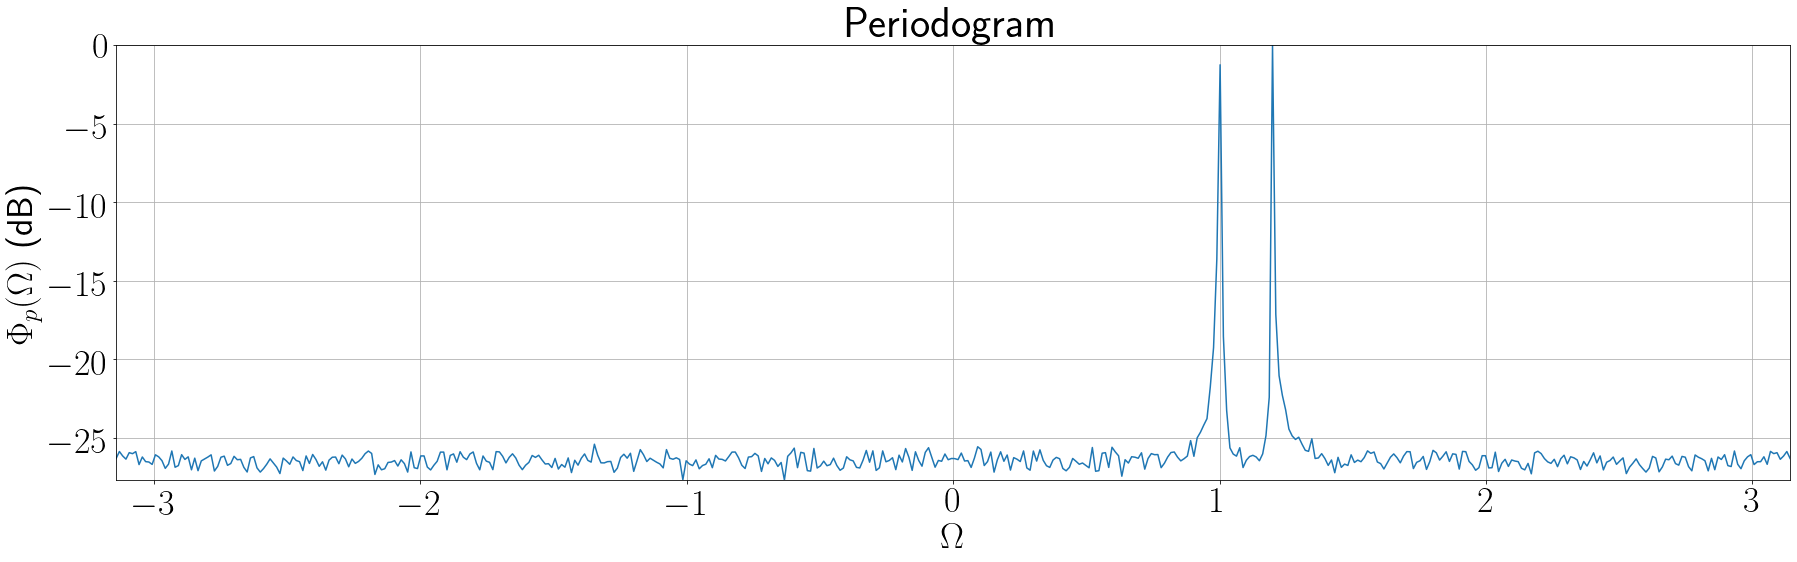

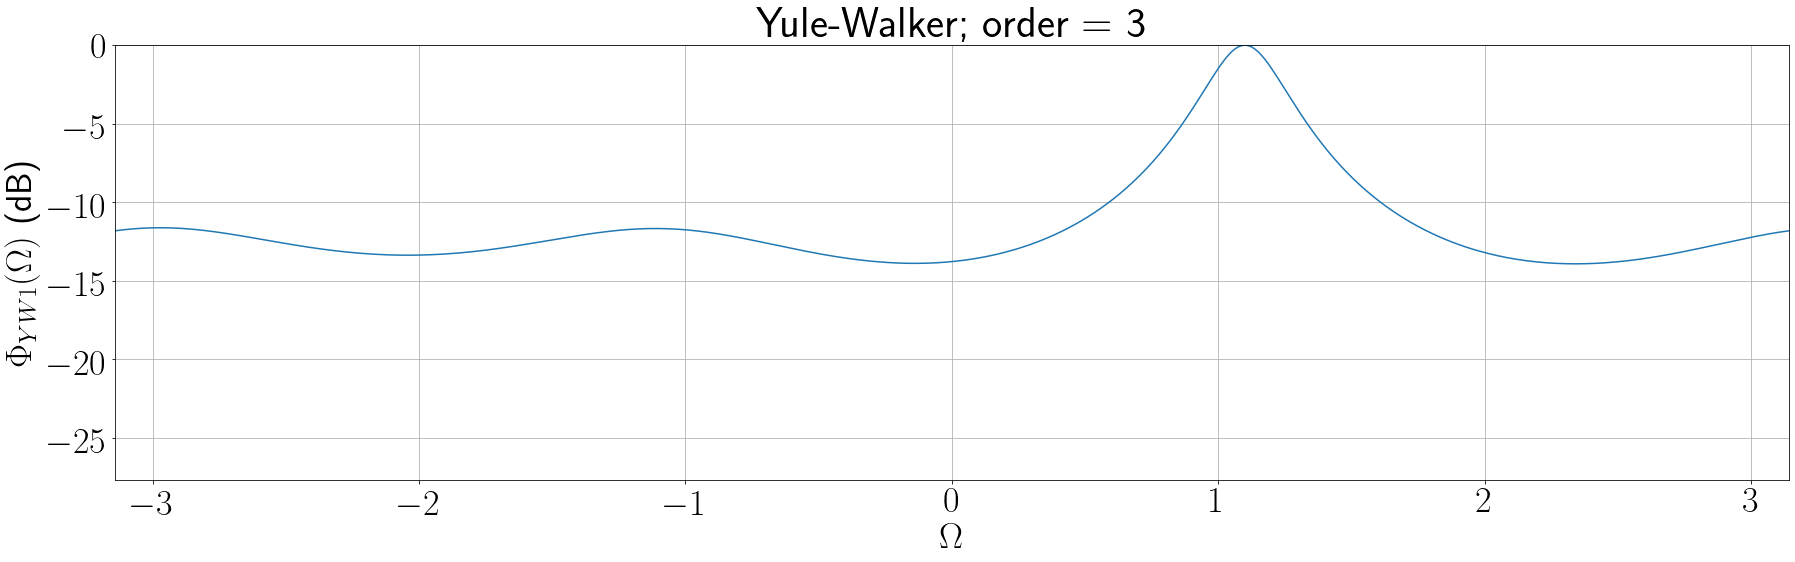

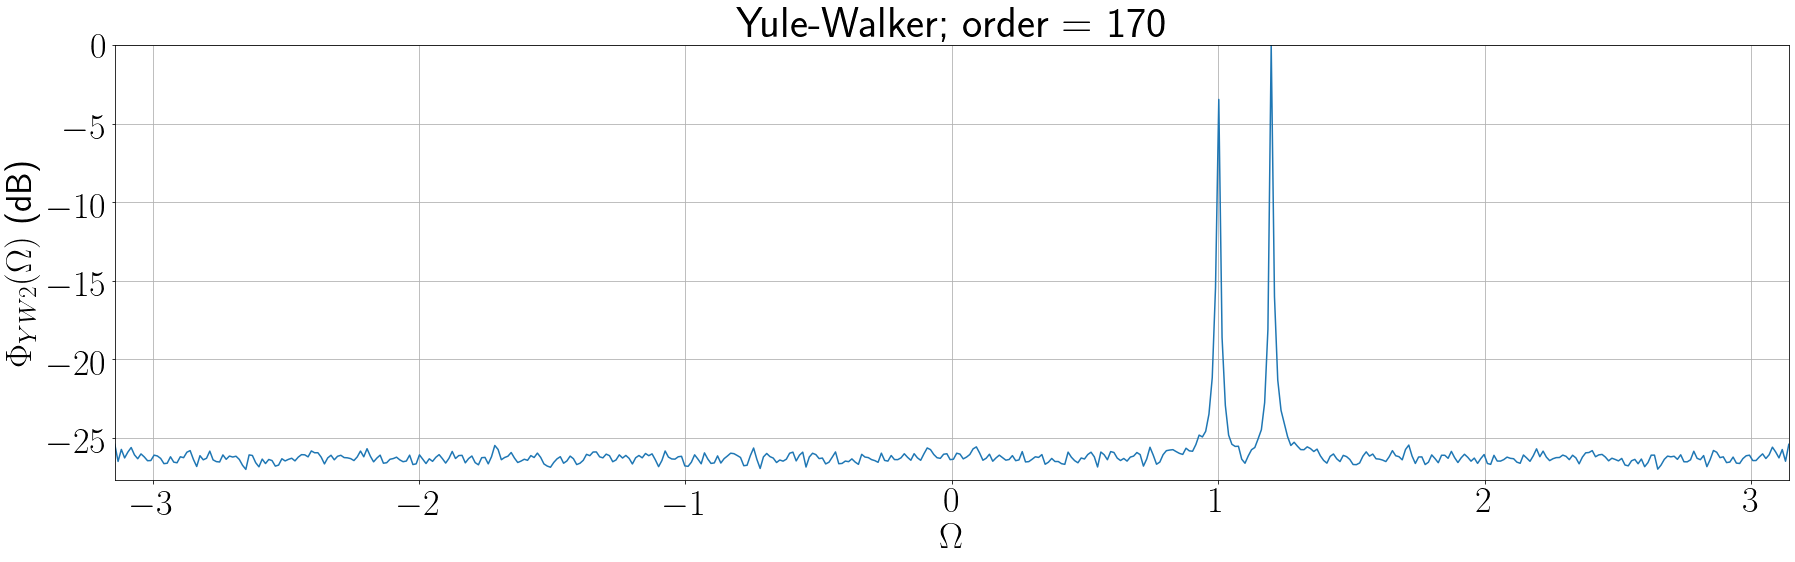

In [7]:
# get min value for equally scaling all plots 

min_val = np.min( np.concatenate( (psd_per_average, \
                     psd_yulewalker_average, \
                        psd_yulewalker_2_average ) ) )
min_val = 10 * np.log10( min_val )

# plot psds
plt.figure()    

plt.plot(Ome, 10*np.log10( psd_per_average ) )    
plt.grid(True)
plt.title('Periodogram')
plt.axis([- np.pi, np.pi, min_val, 0])
plt.xlabel('$\Omega$')   
plt.ylabel('$\Phi_p(\Omega)$ (dB)')


plt.figure()
plt.plot(Ome,  10*np.log10( psd_yulewalker_average ) )    
plt.grid(True) 
plt.title('Yule-Walker; order = '+str(q))
plt.axis([- np.pi, np.pi, min_val, 0])
plt.xlabel('$\Omega$')
plt.ylabel('$\Phi_{YW 1}(\Omega)$ (dB)')

plt.figure()    
plt.plot(Ome,  10*np.log10( psd_yulewalker_2_average ) )
plt.grid(True) 
plt.title('Yule-Walker; order = '+str(q_2))
plt.axis([- np.pi, np.pi, min_val, 0])
plt.xlabel('$\Omega$')    
plt.ylabel('$\Phi_{YW 2}(\Omega)$ (dB)')
